In [2]:
%pip install tqdm

Note: you may need to restart the kernel to use updated packages.


# preprocessing

In [3]:
import numpy as np
import matplotlib.pyplot as plt
#Plot the animation
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
pos=np.load('data_npy/100_3.npy')
vid=np.load('data_video/100_3.npy')
midline=np.load('data_midline/100_3_consistent.npy')
velocity =midline[1:,:,1,:]-midline[:-1,:,1,:]
head=midline[:,:,0,:]-midline[:,:,1,:]
tail=midline[:,:,2,:]-midline[:,:,1,:]

phi= np.arctan2(head[:,:,1], head[:,:,0])
# angular_speed= angle_between_2vec(head[1:,:,:], head[:-1,:,:], axis=2) 
L1=np.linalg.norm(head, axis=2)
L2=np.linalg.norm(tail, axis=2)
Observer_index=0
R=500
Observed_vector=midline[:,None,:,1,:]-midline[:,:,None,1,:]
Observed_distance=np.linalg.norm(Observed_vector, axis=3)
# Observed_phi=angle_between_2vec(head[:,:,None,:], Observed_vector, axis=3)
Observed_index=Observed_distance<=R

In [4]:
def get_observations_debug(midline, observer_index, R):
    """
    取得指定魚在每個時間點觀察到的其他魚的座標與距離（座標為觀察者本地座標）。
    midline: (T, N, 3, 2) 時間、魚數、身體點、xy座標
    observer_index: 指定觀察者的index (int)
    R: 觀察半徑
    回傳: List，每個元素為該時間點觀察到的魚的index與本地座標
    """
    T, N = midline.shape[0], midline.shape[1]
    observer_pos = midline[:, observer_index, 1, :]  # 取身體中心點
    all_pos = midline[:, :, 1, :]
    observations = []
    for t in range(T):
        # 計算距離
        vec = all_pos[t] - observer_pos[t]
        dist = np.linalg.norm(vec, axis=1)
        # 找出在半徑R內且不是自己
        mask = (dist <= R) & (np.arange(N) != observer_index)
        observed_indices = np.where(mask)[0]
        observed_coords_local = vec[mask]  # 本地座標
        observations.append({
            'time': t,
            'observed_indices': observed_indices,
            'observed_coords': observed_coords_local,
            'distances': dist[mask]
        })
    return observations

# 範例：取得第0隻魚在每個時間點觀察到的其他魚（本地座標）
observations = get_observations_debug(midline, observer_index=Observer_index, R=R)
#print frame 0,1,10,20
for i in [0, 1, 10, 20]:
    obs = observations[i]
    print(f"Time {obs['time']}:")
    for idx, coord, dist in zip(obs['observed_indices'], obs['observed_coords'], obs['distances']):
        print(f"  Fish {idx} at local coords {coord}, distance {dist:.2f}")

Time 0:
  Fish 6 at local coords [346.88428   20.908936], distance 347.51
  Fish 9 at local coords [-254.6908  -396.36304], distance 471.14
  Fish 16 at local coords [-17.138916 327.9983  ], distance 328.45
  Fish 28 at local coords [-385.66016  265.40576], distance 468.16
  Fish 32 at local coords [ -67.39795 -206.62915], distance 217.34
  Fish 35 at local coords [-20.097168 107.00464 ], distance 108.88
  Fish 37 at local coords [-103.754395 -428.9259  ], distance 441.30
  Fish 44 at local coords [-346.85657  351.32715], distance 493.70
  Fish 64 at local coords [ 130.3601  -212.21313], distance 249.05
  Fish 70 at local coords [-368.2235  -120.14258], distance 387.33
  Fish 71 at local coords [ 269.95972 -168.18799], distance 318.07
  Fish 89 at local coords [178.6897  170.61987], distance 247.07
  Fish 98 at local coords [ -24.001709 -193.46509 ], distance 194.95
Time 1:
  Fish 6 at local coords [348.5686    11.372803], distance 348.75
  Fish 9 at local coords [-242.82227 -409.43213

## getting observation

Processing time points: 100%|██████████| 19526/19526 [00:36<00:00, 535.82it/s]


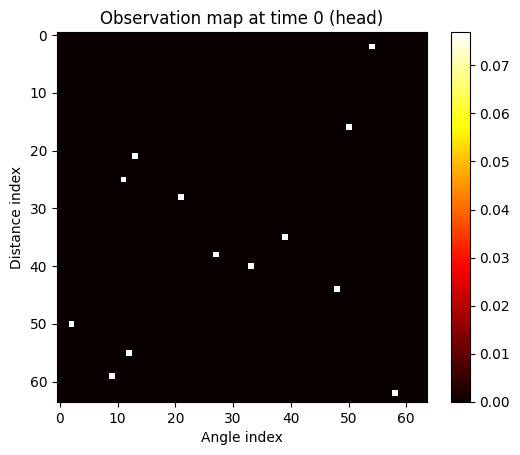

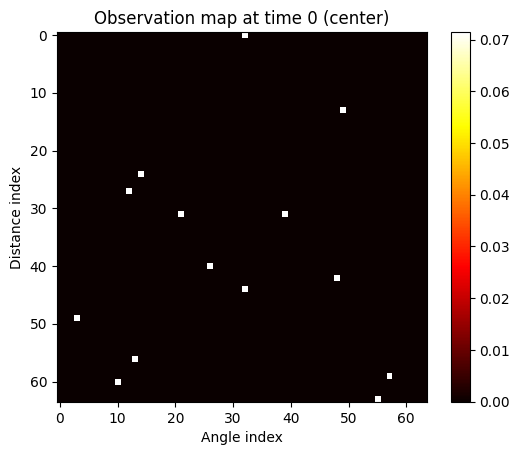

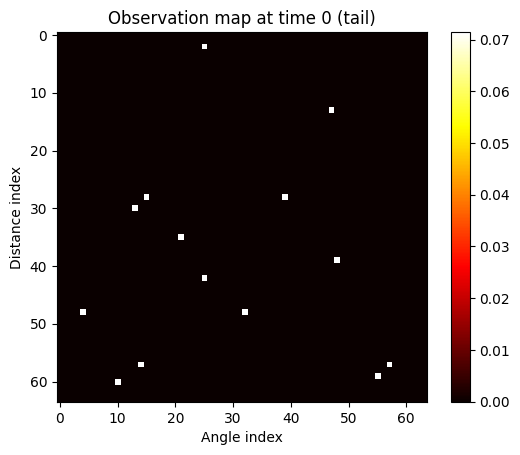

In [ ]:
grid_size = 64

    # we get observations of a fish at each time point
    # which it does not need to know the index of other fish it observes
    # but it knows the local coordinates of the fish it observes
    # and there angle with respect to the observer
    #then map it into a 2d array of size (grid_size, grid_size)
    #with row as distance and column as angle
    # and we further make 3 observations map with respect to head, tail and center
    #so the output will be (3, grid_size, grid_size)
    #reminds: the fish can also observe itself(head, center, tail), to ensure where it is facing, and it will be at the center of the map
    # 取得 head, center, tail 的座標

    # the 3 observation maps should be related to:
    # head: head_pos - center_pos of the observer
    # center: center_pos - center_pos of the observer
    # tail: tail_pos - center_pos of the observer
def get_observations(midline, observer_index, R, grid_size=64):
    T, N = midline.shape[0], midline.shape[1]
    
    # Extract positions
    head_pos = midline[:, :, 0, :]  # (T, N, 2)
    center_pos = midline[:, :, 1, :]  # (T, N, 2)
    tail_pos = midline[:, :, 2, :]  # (T, N, 2)
    
    observer_pos = midline[:, observer_index, 1, :]  # (T, 2)

    # Initialize observation maps
    obs_maps = np.zeros((T, 3, grid_size, grid_size))

    # Angle and distance bins
    angle_bins = np.linspace(-np.pi, np.pi, grid_size + 1)
    distance_bins = np.linspace(0, R, grid_size + 1)

    # Iterate through each time point
    for t in tqdm(range(T), desc="Processing time points"):
        for n in range(N):
            # if n == observer_index:
            #     continue

            # Calculate vectors
            head_vector = head_pos[t, n] - observer_pos[t]
            center_vector = center_pos[t, n] - observer_pos[t]
            tail_vector = tail_pos[t, n] - observer_pos[t]

            #print the head_vector, center_vector, tail_vector for the observer index at time = 0
            """ 
            if t == 0 and n == observer_index:
                print("Head vector:", head_vector)
                print("Center vector:", center_vector)
                print("Tail vector:", tail_vector)
            """

            # Calculate distances and angles
            head_distance = np.linalg.norm(head_vector)
            center_distance = np.linalg.norm(center_vector)
            tail_distance = np.linalg.norm(tail_vector)

            head_angle = np.arctan2(head_vector[1], head_vector[0])
            center_angle = np.arctan2(center_vector[1], center_vector[0])
            tail_angle = np.arctan2(tail_vector[1], tail_vector[0])

            # Convert distances and angles to indices
            head_distance_index = np.digitize(head_distance, distance_bins) - 1
            center_distance_index = np.digitize(center_distance, distance_bins) - 1
            tail_distance_index = np.digitize(tail_distance, distance_bins) - 1

            head_angle_index = np.digitize(head_angle, angle_bins) - 1
            center_angle_index = np.digitize(center_angle, angle_bins) - 1
            tail_angle_index = np.digitize(tail_angle, angle_bins) - 1

            # Increment observation maps
            if 0 <= head_distance_index < grid_size and 0 <= head_angle_index < grid_size:
                obs_maps[t, 0, head_distance_index, head_angle_index] += 1
            if 0 <= center_distance_index < grid_size and 0 <= center_angle_index < grid_size:
                obs_maps[t, 1, center_distance_index, center_angle_index] += 1
            if 0 <= tail_distance_index < grid_size and 0 <= tail_angle_index < grid_size:
                obs_maps[t, 2, tail_distance_index, tail_angle_index] += 1

    # Normalize observation maps
    obs_maps /= np.sum(obs_maps, axis=(2, 3), keepdims=True)
    obs_maps = np.nan_to_num(obs_maps)  # Replace NaN with 0
    obs_maps = np.clip(obs_maps, 0, 1)  # Ensure values are between 0 and 1

    return obs_maps

# 範例：取得第0隻魚在每個時間點的觀察地圖
obs_maps = get_observations(midline, observer_index=Observer_index, R=R, grid_size=grid_size)
# 打印第0個時間點的觀察地圖
for ref_idx, ref_name in enumerate(['head', 'center', 'tail']):
    plt.imshow(obs_maps[0, ref_idx], cmap='hot', interpolation='nearest')
    plt.title(f'Observation map at time 0 ({ref_name})')
    plt.colorbar()
    plt.xlabel('Angle index')
    plt.ylabel('Distance index')
    plt.show()


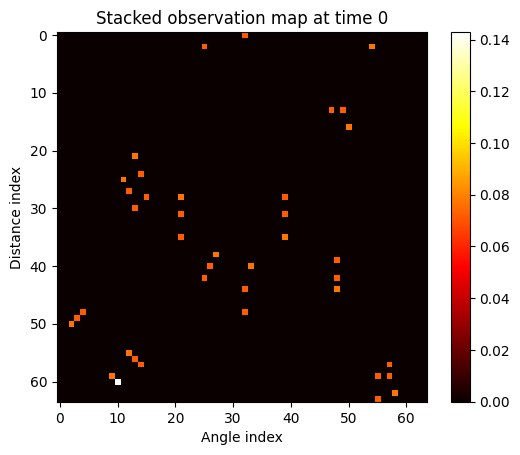

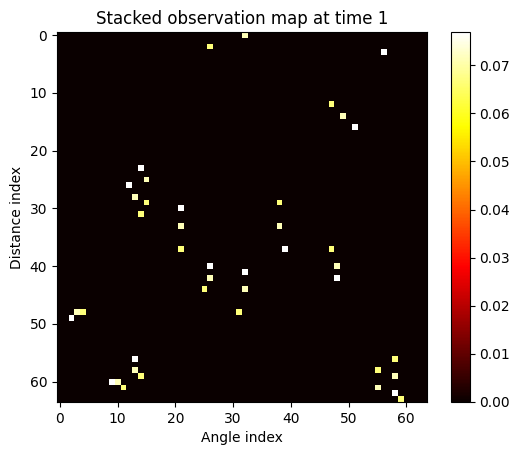

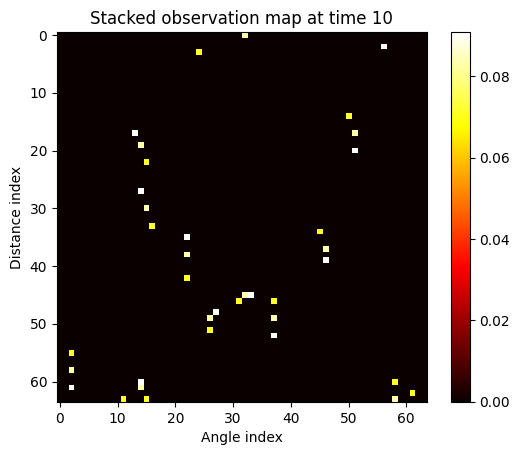

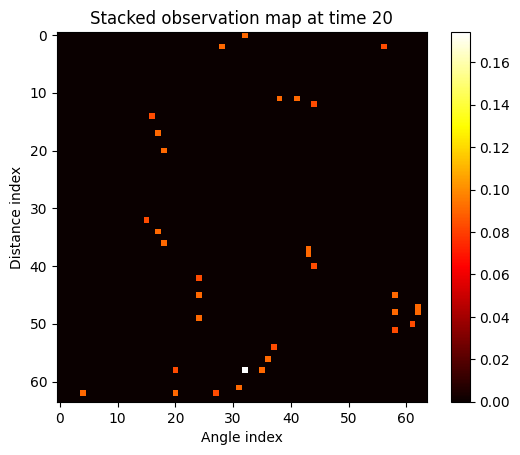

In [6]:
# stack 3 map into one map and print it
#input wil be (T, 3, grid_size, grid_size)
#output will be (T, grid_size, grid_size)
def stack_obs_maps(obs_maps):
    """
    將觀察地圖堆疊成一個地圖，將三個觀察點的地圖合併。
    obs_maps: (T, 3, grid_size, grid_size)
    回傳: (T, grid_size, grid_size)
    """
    return np.sum(obs_maps, axis=1)

    
obs_maps_stacked = stack_obs_maps(obs_maps)
# 打印堆疊後的觀察地圖
# and only frame 0
for t in [0, 1, 10, 20]:
    plt.imshow(obs_maps_stacked[t], cmap='hot', interpolation='nearest')
    plt.title(f'Stacked observation map at time {t}')
    plt.colorbar()
    plt.xlabel('Angle index')
    plt.ylabel('Distance index')
    plt.show()

## circle boundary observation

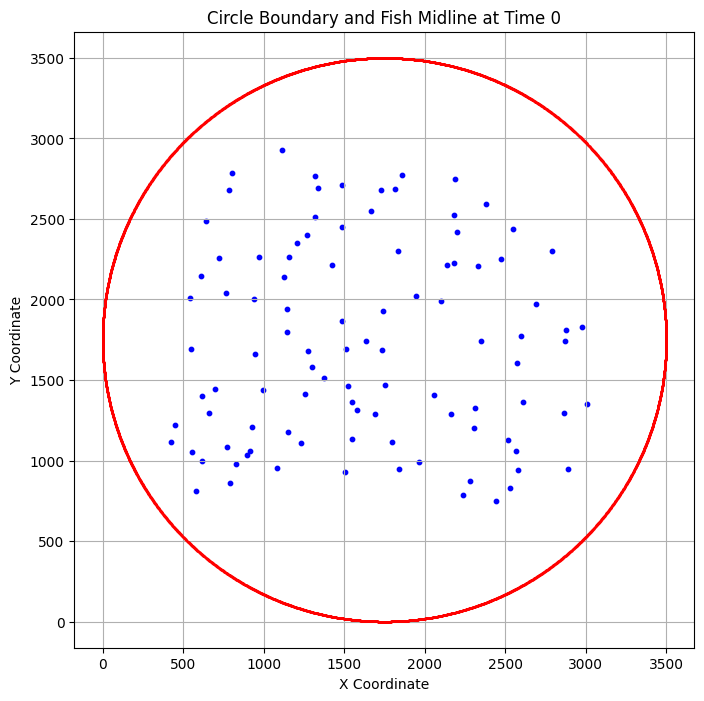

In [9]:
#using mid-point circle algorithm to generate a circle boundary
# center of the boundary is at (boundaries_radius, boundaries_radius)
#radius of boundary = 3500/2
boundaries_radius = 3500 / 2
def mid_point_circle_algorithm(radius):
    """
    使用中點圓算法生成圓的邊界點。
    radius: 圓的半徑
    回傳: 圓的邊界點列表 [(x, y), ...]
    """
    points = []
    x = radius
    y = 0
    d = 1 - radius  # 初始決策參數

    while x >= y:
        # 八分之一對稱性
        points.append((x, y))
        points.append((y, x))
        points.append((-x, y))
        points.append((-y, x))
        points.append((-x, -y))
        points.append((-y, -x))
        points.append((x, -y))
        points.append((y, -x))

        y += 1

        if d <= 0:
            d += 2 * y + 1  # 垂直方向移動
        else:
            x -= 1
            d += 2 * y - 2 * x + 1  # 水平方向移動

    return points
# 生成圓的邊界點
circle_boundary = mid_point_circle_algorithm(boundaries_radius)
# 將圓的邊界點轉換為 numpy 陣列
circle_boundary = np.array(circle_boundary)
# 將圓的邊界點平移到 (0, 0)
circle_boundary = circle_boundary + np.array([boundaries_radius, boundaries_radius])
# plot 圓的邊界點 and all the fish midline at time 0 same time
plt.figure(figsize=(8, 8))
plt.plot(circle_boundary[:, 0], circle_boundary[:, 1], 'r.', markersize=1)
plt.scatter(midline[0, :, 1, 0], midline[0, :, 1, 1], c='b', s=10)
plt.title('Circle Boundary and Fish Midline at Time 0')
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.axis('equal')
plt.grid()
plt.show()

Processing boundaries: 100%|██████████| 19526/19526 [00:01<00:00, 13698.19it/s]


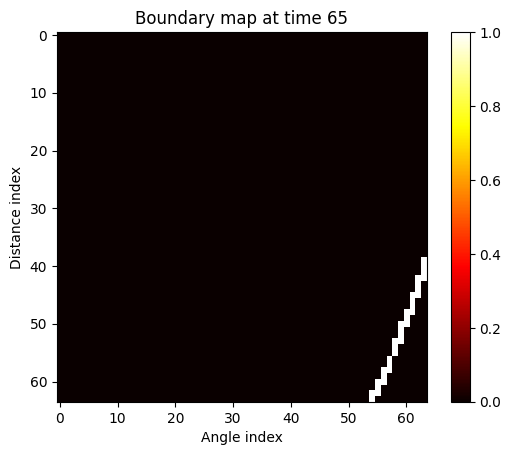

In [20]:
# we add the 4th map specfically to tracing the circle boundary within the view cone of the observer
#however, as the circle boundary  is continuous, we need to use mid-point circle algorithm to digitize the circle boundary
#rules:
#we use the points in circle_boundary as the boundary points

def get_boundaries(midline, observer_index, R, grid_size=64,circle_boundary=None, boundaries_radius=3500/2):
    if circle_boundary is None:
        circle_boundary = mid_point_circle_algorithm(boundaries_radius)
    
    T = midline.shape[0]
    #initialize the observation map
    boundaries = np.zeros((T, 1, grid_size, grid_size))
    observer_pos = midline[:, observer_index, 1, :]  # (T, 2)

    for t in tqdm(range(T), desc="Processing boundaries"):
        # Get the observer's position at time t
        obs_x, obs_y = observer_pos[t]

       # Calculate adjusted positions of the circle boundary points
        adjusted_points = np.array([obs_x, obs_y]) - circle_boundary
        # take the absolute value of the adjusted points
        adjusted_points = np.abs(adjusted_points)

        # Check bounds
        valid_mask = (adjusted_points[:, 0] < R) & (adjusted_points[:, 1] < R)

        # Get valid indices
        valid_indices = np.where(valid_mask)[0]

        # Convert valid points to grid indices
        grid_x = np.clip((adjusted_points[valid_indices, 0] / R) * grid_size, 0, grid_size - 1).astype(int)
        grid_y = np.clip((adjusted_points[valid_indices, 1] / R) * grid_size, 0, grid_size - 1).astype(int)

        # Update boundaries for valid points
        boundaries[t, 0, grid_x, grid_y] = 1  # Mark the boundary point

    return boundaries

#plot the boundary when the first time the observer see the boundary
boundaries = get_boundaries(midline, observer_index=Observer_index, R=R, grid_size=grid_size, circle_boundary=circle_boundary, boundaries_radius=boundaries_radius)
flag = False
count = 0
for t in range(midline.shape[0]):
    if np.any(boundaries[t, 0]):
        count += 1
        if count >= 10:
            plt.imshow(boundaries[t, 0], cmap='hot', interpolation='nearest')
            plt.title(f'Boundary map at time {t}')
            plt.colorbar()
            plt.xlabel('Angle index')
            plt.ylabel('Distance index')
            plt.show()
            flag = True
            break

if not flag:
    print("Observer never sees the boundary within the given radius.")
    

## preprocessing

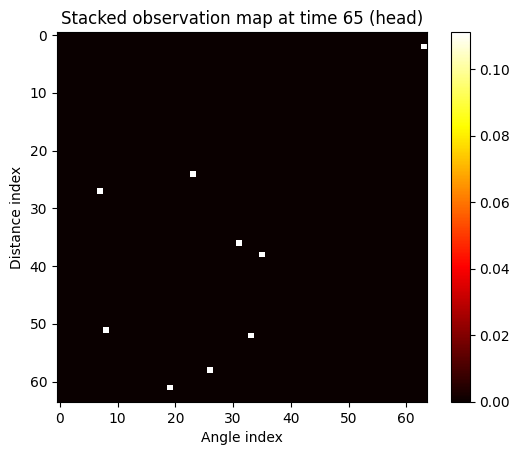

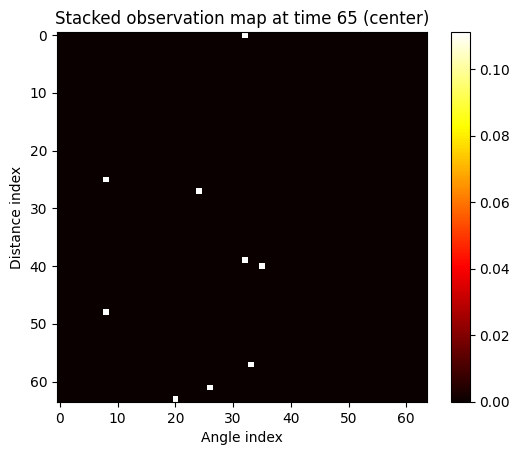

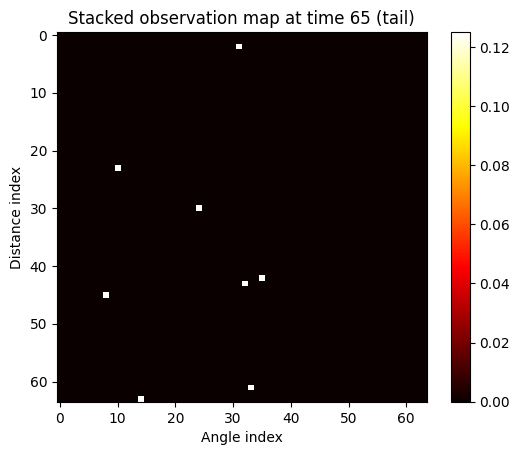

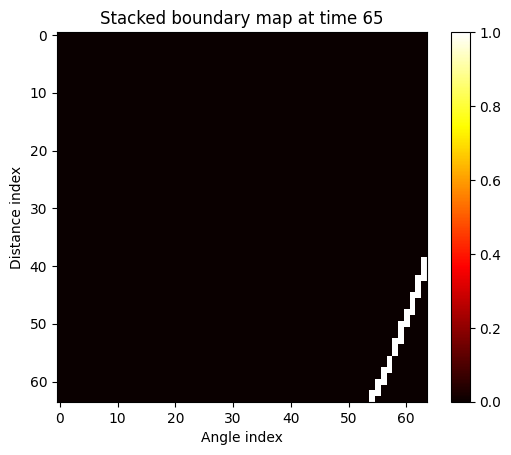

In [ ]:
# stack the boundaries map with the observation maps
def stack_obs_boundaries(obs_maps, boundaries):
    """
    將觀察地圖和邊界地圖堆疊成一個地圖。
    obs_maps: (T, 3, grid_size, grid_size)
    boundaries: (T, 1, grid_size, grid_size)
    回傳: (T, 4, grid_size, grid_size)
    """
    T = obs_maps.shape[0]
    stacked_maps = np.zeros((T, 4, obs_maps.shape[2], obs_maps.shape[3]))
    
    stacked_maps[:, :3] = obs_maps  # 前三個是觀察地圖
    stacked_maps[:, 3] = boundaries[:, 0]  # 第四個是邊界地圖
    
    return stacked_maps
obs_boundaries_stacked = stack_obs_boundaries(obs_maps, boundaries)
# 打印堆疊後的觀察地圖和邊界地圖
# and only frame 0
for t in [65]:
    plt.imshow(obs_boundaries_stacked[t, 0], cmap='hot', interpolation='nearest')
    plt.title(f'Stacked observation map at time {t} (head)')
    plt.colorbar()
    plt.xlabel('Angle index')
    plt.ylabel('Distance index')
    plt.show()

    plt.imshow(obs_boundaries_stacked[t, 1], cmap='hot', interpolation='nearest')
    plt.title(f'Stacked observation map at time {t} (center)')
    plt.colorbar()
    plt.xlabel('Angle index')
    plt.ylabel('Distance index')
    plt.show()

    plt.imshow(obs_boundaries_stacked[t, 2], cmap='hot', interpolation='nearest')
    plt.title(f'Stacked observation map at time {t} (tail)')
    plt.colorbar()
    plt.xlabel('Angle index')
    plt.ylabel('Distance index')
    plt.show()

    plt.imshow(obs_boundaries_stacked[t, 3], cmap='hot', interpolation='nearest')
    plt.title(f'Stacked boundary map at time {t}')
    plt.colorbar()
    plt.xlabel('Angle index')
    plt.ylabel('Distance index')
    plt.show()

### generate data for all 

## animation testing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
# Show the animation as html
from IPython.display import HTML

# plot the animation of head, center and tail of the fish 0 respectively for each time point
# by using the data weget in obs_map
def plot_fish_animation(midline, observer_index=0, interval=100,obs_maps=None,grid_size=64, R=500):
    
    if obs_maps is None:
        obs_maps = get_observations(midline, observer_index=observer_index, R=R)
    T, N = midline.shape[0], midline.shape[1]
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_aspect('equal')
    ax.set_title(f'Fish {observer_index} Observations Animation')
    ax.set_xlabel('X Position (local)')
    ax.set_ylabel('Y Position (local)')

    # 初始化三個魚的頭部、中心和尾部位置
    head_line, = ax.plot([], [], 'ro', label='Head')
    center_line, = ax.plot([], [], 'go', label='Center')
    tail_line, = ax.plot([], [], 'bo', label='Tail')

    # 初始化觀察地圖
    obs_images = []
    for ref_idx, ref_name in enumerate(['head', 'center', 'tail']):
        obs_img = ax.imshow(obs_maps[0, ref_idx], cmap='hot', interpolation='nearest', alpha=0.5)
        obs_images.append(obs_img)
    ax.legend()

    def init():
        head_line.set_data([], [])
        center_line.set_data([], [])
        tail_line.set_data([], [])
        for img in obs_images:
            img.set_array(np.zeros_like(img.get_array()))
        return head_line, center_line, tail_line, *obs_images
    def update(frame):
        head_pos = midline[frame, observer_index, 0, :]
        center_pos = midline[frame, observer_index, 1, :]
        tail_pos = midline[frame, observer_index, 2, :]
        
        head_line.set_data([head_pos[0]], [head_pos[1]])
        center_line.set_data([center_pos[0]], [center_pos[1]])
        tail_line.set_data([tail_pos[0]], [tail_pos[1]])
        
        for ref_idx in range(3):
            obs_images[ref_idx].set_array(obs_maps[frame, ref_idx])
        
        return head_line, center_line, tail_line, *obs_images
    ani = FuncAnimation(fig, update, frames=T, init_func=init, blit=True, interval=interval)
    plt.close(fig)  # 防止在Jupyter中顯示多餘的圖形
    return HTML(ani.to_jshtml())
# 使用範例
#animation_html = plot_fish_animation(midline, observer_index=Observer_index, interval=100, obs_maps=obs_maps, grid_size=grid_size, R=R)
from IPython.display import display
#display(animation_html)



# training

## CNN

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader

#aim: using the observation maps to train a CNN model to predict the behavior of the fish
# the model will take the observation maps as input and output the target action of the fish
# the target action will be choosing moving direction
#we used changing of center position of the observer fish to calculate the real moving direction of the fish
#and compare it with our model's output for training and loss calculation

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Calculate movement direction targets from center position changes
def calculate_movement_targets(midline, observer_index):
    """
    Calculate the real movement direction of the fish from center position changes
    Returns: angles of movement direction for each timestep
    """
    center_pos = midline[:, observer_index, 1, :]  # (T, 2)
    movements = center_pos[1:] - center_pos[:-1]  # (T-1, 2)
    angles = np.arctan2(movements[:, 1], movements[:, 0])  # (T-1,)
    return angles

# Dataset class for fish observation data
class FishObservationDataset(Dataset):
    def __init__(self, obs_maps, movement_targets):
        self.obs_maps = torch.FloatTensor(obs_maps[:-1])  # Remove last frame (no target)
        self.targets = torch.FloatTensor(movement_targets)
        
    def __len__(self):
        return len(self.obs_maps)
    
    def __getitem__(self, idx):
        return self.obs_maps[idx], self.targets[idx]

# CNN Model for predicting fish movement direction
class FishMovementCNN(nn.Module):
    def __init__(self, input_channels=4, grid_size=64):
        super(FishMovementCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.5)
        
        # Calculate flattened size after convolutions and pooling
        conv_output_size = (grid_size // 8) * (grid_size // 8) * 128
        
        self.fc1 = nn.Linear(conv_output_size, 256)
        self.fc2 = nn.Linear(256, 64)
        self.fc3 = nn.Linear(64, 2)  # Output: (cos(angle), sin(angle)) for direction
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        # Normalize to unit circle (direction vector)
        x = F.normalize(x, p=2, dim=1)
        return x

# Calculate movement targets
movement_targets = calculate_movement_targets(midline, Observer_index)

# Create dataset and dataloader
dataset = FishObservationDataset(obs_maps, movement_targets)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model, loss function, and optimizer
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using MPS device for training")
else:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Using CUDA device for training")
model = FishMovementCNN(input_channels=3, grid_size=grid_size).to(device)

# Custom loss function for angular predictions
def angular_loss(pred, target):
    # Convert target angles to unit vectors
    target_vec = torch.stack([torch.cos(target), torch.sin(target)], dim=1)
    # Cosine similarity loss (1 - cosine_similarity)
    cos_sim = F.cosine_similarity(pred, target_vec, dim=1)
    return 1 - cos_sim.mean()

optimizer = optim.Adam(model.parameters(), lr=0.001)



Using MPS device for training


In [23]:
# Training loop
num_epochs = 50
model.train()

for epoch in tqdm(range(num_epochs), desc="Training Epochs"):
    total_loss = 0
    for batch_idx, (data, target) in enumerate(dataloader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = angular_loss(output, target)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    if epoch % 10 == 0:
        print(f'Epoch [{epoch}/{num_epochs}], Average Loss: {avg_loss:.4f}')

print("Training completed!")

# Test the model
model.eval()
with torch.no_grad():
    # Test on a sample
    test_input = torch.FloatTensor(obs_maps[0:1]).to(device)
    prediction = model(test_input)
    predicted_angle = torch.atan2(prediction[0, 1], prediction[0, 0])
    actual_angle = movement_targets[0]
    
    print(f"Predicted angle: {predicted_angle.item():.4f} radians")
    print(f"Actual angle: {actual_angle:.4f} radians")
    print(f"Difference: {abs(predicted_angle.item() - actual_angle):.4f} radians")

Training Epochs:   2%|▏         | 1/50 [00:09<07:32,  9.24s/it]

Epoch [0/50], Average Loss: 1.0002


Training Epochs:  22%|██▏       | 11/50 [01:35<05:30,  8.48s/it]

Epoch [10/50], Average Loss: 0.0397


Training Epochs:  42%|████▏     | 21/50 [02:58<03:59,  8.26s/it]

Epoch [20/50], Average Loss: 0.0343


Training Epochs:  62%|██████▏   | 31/50 [04:20<02:36,  8.23s/it]

Epoch [30/50], Average Loss: 0.0288


Training Epochs:  82%|████████▏ | 41/50 [05:44<01:16,  8.46s/it]

Epoch [40/50], Average Loss: 0.0249


Training Epochs: 100%|██████████| 50/50 [07:03<00:00,  8.48s/it]


Training completed!
Predicted angle: 2.2283 radians
Actual angle: 2.3230 radians
Difference: 0.0947 radians


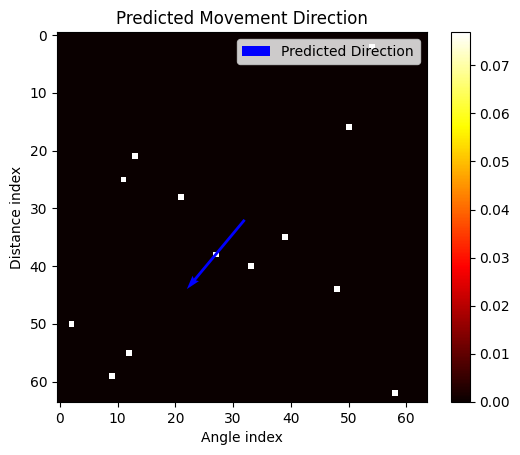

In [24]:
#based on the model's prediction, we can visualize the predicted movement direction on the observation map
def visualize_prediction(obs_map, prediction, grid_size=64):
    """
    Visualize the predicted movement direction on the observation map.
    obs_map: (grid_size, grid_size) observation map
    prediction: (2,) predicted direction vector (cos(angle), sin(angle))
    grid_size: size of the observation map
    """
    plt.imshow(obs_map, cmap='hot', interpolation='nearest')
    plt.colorbar()
    
    # Draw the predicted direction vector
    center = (grid_size // 2, grid_size // 2)
    arrow_length = grid_size // 4  # Length of the arrow
    end_point = (int(center[0] + prediction[0].item() * arrow_length),
                 int(center[1] + prediction[1].item() * arrow_length))
    
    plt.quiver(center[0], center[1], end_point[0] - center[0], end_point[1] - center[1],
               angles='xy', scale_units='xy', scale=1, color='blue', label='Predicted Direction')
    
    plt.title('Predicted Movement Direction')
    plt.xlabel('Angle index')
    plt.ylabel('Distance index')
    plt.legend()
    plt.show()
    # Visualize the prediction for the first observation map
visualize_prediction(obs_maps[0, 0], prediction[0].cpu(), grid_size=grid_size)

In [34]:
#generate a video of the fish movement with the predicted direction
#which inside the test environment, every fish are using the same model to predict their movement direction
#and of course each of them have their own observation map
#and they will choose their own direction based on the observation map
#and update their position based on the predicted direction
#repeat and generate a video of the fish movement with the predicted direction
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
def generate_fish_movement_video(model, boundaries_radius, N, T, R, grid_size=64):
    # Generate a video of fish movement based on the model's predictions
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim(0, boundaries_radius * 2)
    ax.set_ylim(0, boundaries_radius * 2)
    ax.set_aspect('equal')
    ax.set_title('Fish Movement Simulation')    
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    #step 1: initialize
    # randomly initialize the positions of N fish within the circle boundary
    fish_positions = np.random.rand(N, 2) * boundaries_radius * 2
    midline = np.zeros((T, N, 3, 2))  # (T, N, 3 points (head, center, tail), 2 coordinates (x, y))
    midline[:, :, 1, :] = fish_positions  # Set center positions for all fish at time 0
    midline[:, :, 0, :] = fish_positions + np.random.randn(N, 2) * 10  # Random head positions
    midline[:, :, 2, :] = fish_positions - (midline[:, :, 0, :] - midline[:, :, 1, :])  # Set tail positions based on head and center

    # Initialize the observation maps for each fish
    obs_maps = np.zeros((T, N, 4, grid_size, grid_size))
    for i in range(N):
        # Initialize the observer map for each fish
        obs_maps[:, i, :3] = get_observations(midline, observer_index=i, R=R, grid_size=grid_size)
        # Initialize the boundary map
        #boundaries = np.zeros((T, 1, grid_size, grid_size))
        circle_boundary = mid_point_circle_algorithm(boundaries_radius)
        obs_maps[:, i, 3] = get_boundaries(midline, observer_index=i, R=R, grid_size=grid_size, circle_boundary=circle_boundary, boundaries_radius=boundaries_radius)[:,0]

    def update(frame):
        ax.clear()
        ax.set_xlim(0, boundaries_radius * 2)
        ax.set_ylim(0, boundaries_radius * 2)
        ax.set_aspect('equal')
        ax.set_title(f'Fish Movement Simulation - Frame {frame}')
        ax.set_xlabel('X Coordinate')
        ax.set_ylabel('Y Coordinate')

        for i in range(N):
            # Get the observation map for the fish
            obs_map = obs_maps[frame, i]
            print("obs_map.shape:", obs_map.shape)
            # Predict the movement direction using the model
            input_tensor = torch.FloatTensor(obs_map).unsqueeze(0).to(device)
            print("input_tensor.shape:", input_tensor.shape)
            with torch.no_grad():
                prediction = model(input_tensor).cpu().numpy()[0]  
            # Calculate the new position based on the predicted direction
            center_pos = midline[frame, i, 1, :]  # Center position
            arrow_length = grid_size // 4  # Length of the arrow
            new_pos = center_pos + np.array([prediction[0], prediction[1]]) * arrow_length
            # Ensure the new position is within the circle boundary
            distance_from_center = np.linalg.norm(new_pos - np.array([boundaries_radius, boundaries_radius]))
            if distance_from_center > boundaries_radius:
                # If out of bounds, keep the position at the boundary
                direction = (new_pos - np.array([boundaries_radius, boundaries_radius])) / distance_from_center
                new_pos = np.array([boundaries_radius, boundaries_radius]) + direction * boundaries_radius
            # Update the midline positions
            midline[frame, i, 1, :] = new_pos  # Update center
            midline[frame, i, 0, :] = new_pos + np.random.randn(2) * 10  # Update head position randomly
            midline[frame, i, 2, :] = new_pos - (midline[frame, i, 0, :] - midline[frame, i, 1, :]) # Update tail position based on head and center
            #update the observation maps for the fish
            obs_maps[frame, i, :3] = get_observations(midline, observer_index=i, R=R, grid_size=grid_size)
            obs_maps[frame, i, 3] = get_boundaries(midline, observer_index=i, R=R, grid_size=grid_size, circle_boundary=circle_boundary, boundaries_radius=boundaries_radius)
            # Plot the fish positions
            ax.plot(midline[frame, i, 0, 0], midline[frame, i, 0, 1], 'ro', markersize=5)
            ax.plot(midline[frame, i, 1, 0], midline[frame, i, 1, 1], 'go', markersize=5)
            ax.plot(midline[frame, i, 2, 0], midline[frame, i, 2, 1], 'bo', markersize=5)
            # Draw the predicted direction vector
            center = midline[frame, i, 1, :]
            end_point = center + np.array([prediction[0], prediction[1]]) * arrow_length
            ax.quiver(center[0], center[1], end_point[0] - center[0], end_point[1] - center[1],
                       angles='xy', scale_units='xy', scale=1, color='blue', label='Predicted Direction' if i == 0 else "") 
        ax.legend()
    ani = FuncAnimation(fig, update, frames=T, interval=100, repeat=False)
    plt.close(fig)  # Prevent displaying the static figure in Jupyter
    return HTML(ani.to_jshtml())

# Generate the fish movement video
video_html = generate_fish_movement_video(model, boundaries_radius, N=10, T=16, R=R, grid_size=grid_size)
# Display the video
from IPython.display import display
display(video_html)





Processing boundaries: 100%|██████████| 16/16 [00:00<00:00, 572.08it/s]


obs_map.shape: (4, 64, 64)
input_tensor.shape: torch.Size([1, 4, 64, 64])


RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[1, 4, 64, 64] to have 3 channels, but got 4 channels instead

In [26]:
#save the model and animation
torch.save(model.state_dict(), 'fish_movement_cnn.pth')
# Save the animation as HTML
with open('fish_movement_animation.html', 'w') as f:
    f.write(animation_html.data)
print("Model and animation saved successfully!")
# --- IGNORE ---

NameError: name 'animation_html' is not defined

In [ ]:
#